In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

import colorednoise as cn

from hr.util import EsmModel, _PINK_FILTRE_COEFFS
from hr.process import Esprit, Ester, NoiseWhitening
from util.util import to_db

### Simple noiseless 'harmonic' signal

In [2]:
sr = 44100
n_s = 100000
n_fft = 4096

r = 8 # number of sinusoids

deltas = rng.uniform(0.001, 0.01, r)
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_esm = EsmModel(deltas, nus, amps, phis)

x_sine = x_esm.synth(n_s)

print(nus * sr)
print(deltas * sr)

[3711.90703018 3699.13199887 4624.25393767 1045.32345363 7038.72625954
 2930.24726624 6615.59407035 4710.5880781 ]
[314.92545452  65.46156236 131.5608335  117.27717167 113.91705214
 366.42030969 410.57562972 153.87237849]


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


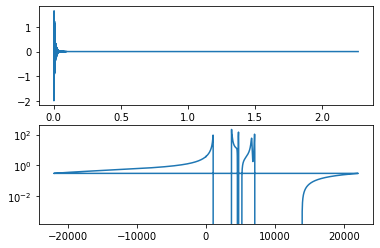

In [3]:
ts_plot = np.arange(n_s) / sr # times in seconds
nus_plot = np.fft.fftfreq(n_fft)

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.semilogy(nus_plot * sr, x_sine_ft)

In [4]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

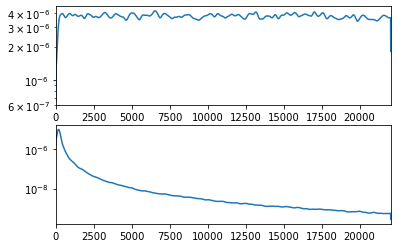

In [5]:
white_noise = rng.random(n_s)

pink_noise = cn.powerlaw_psd_gaussian(2, n_s)    # synthesizing noise
#pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft)

plt.figure()
plt.title("White and pink noises")
plt.subplot(2, 1, 1)
plt.semilogy(fs_psd, white_noise_psd)
plt.xlim(np.array([0, 0.5])*sr)
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_psd, pink_noise_psd)
plt.show()

### Whitening the noise
#### Seems to work better with louder noise..

In [6]:
noise_ratio = 0.1
noise = noise_ratio*pink_noise

x = x_sine + noise
snr = to_db(np.mean(np.real(x))/np.mean(noise))
print(f'SNR={snr} dB')

smoothing_factor = 4
ar_ordre = 10

SNR=0.006159533069220374 dB


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


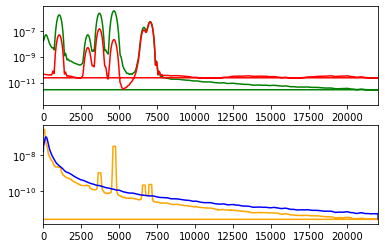

In [7]:

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft)

noise_psd_est = NoiseWhitening.estimate_noise_psd(x, fs=sr, n_fft=n_fft, smoothing_factor=smoothing_factor)
noise_filtre_coeffs_est = NoiseWhitening.estimate_noise_ar_coeffs(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, smoothing_factor=smoothing_factor)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = NoiseWhitening.whiten(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.title("PSD of the noised synthesised signal")
plt.subplot(2, 1, 1)
plt.xlim(np.array([0, 0.5]) * sr)
plt.semilogy(fs_x_psd, x_psd, c='green')
plt.semilogy(fs_x_psd, x_white_psd, c='r')
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_x_psd, noise_psd_est, c='orange')
plt.semilogy(fs_noise_psd, noise_psd, c='b')
plt.show()

In [8]:
# ipd.Audio(np.real(x_sine)/np.max(np.abs(x_sine)), rate=sr)
# ipd.Audio(np.real(x)/np.max(np.abs(x)), rate=sr)
ipd.Audio(np.real(x_white)/np.max(np.abs(x_white)), rate=sr)

### ESM model ordre estimation

#### Does not seem to be resistant to coloured noise!

According to the article, $p_{max}$ should be 
much lower than $n$.
So according to our expectation on $r$, we should choose
$n$ large enough.

Still unclear, but if $p_{max} > r$
the _a posteriori error bound_ from $E$ 
gives some indication somehow?

In the article:

For each eigenvalue ̂$\hat{z}$ of $\Phi(p)$, 
there is an eigenvalue $z_k$ of $\Phi(r)$ for which:

$$
|\hat{z} − z_k| \leq \kappa_2 ||E(p)||_2
$$ 


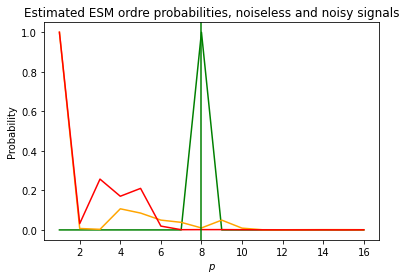

Ordre of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=4, Whitened=5


In [9]:
n_est = 64
p_max = 16
thresh_ratio = 0.1
ps = np.arange(1,p_max+1)

j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = Ester.inverse_error_func(x, n=n_est, p_max=p_max)
j_white = Ester.inverse_error_func(x_white, n=n_est, p_max=p_max)

r_est_sine = Ester.estimate_esm_ordre(x_sine, n=n_est, p_max=p_max, thresh_ratio=thresh_ratio)
r_est_noise = Ester.estimate_esm_ordre(x, n=n_est, p_max=p_max, thresh_ratio=thresh_ratio)
r_est_white = Ester.estimate_esm_ordre(x_white, n=n_est, p_max=p_max, thresh_ratio=thresh_ratio)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='g')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='r')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')


### Test of the model with whitened signal

[0.02370348 0.06644552 0.08388054 0.08417023 0.10485837 0.10681606
 0.15001347 0.15960831]
[0.02388656 0.08379639 0.10470094 0.15020872 0.15981712]


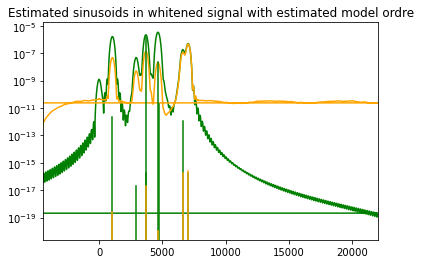

In [10]:
x_esm_est, _, _ = Esprit.estimate_esm(x_white, n_est, r_est_white)

print(np.sort(x_esm.nus))
print(np.sort(x_esm_est.nus))

plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='g')
plt.semilogy(fs_x_psd, x_white_psd, c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='orange')
plt.show()


In [11]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Filter bank

/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


[ 2.60002163e-02  6.89126026e+02  1.37831221e+03  6.71489050e+03
 -1.91738189e+03  5.77074638e+03  2.06742993e+03  7.40497527e+03
 -1.22717756e+03  6.48106182e+03  3.44572573e+03  8.09425814e+03
 -5.39086048e+02 -9.51053480e+02  1.43061435e+02 -1.83405190e+02
  7.82313474e+03  8.78265538e+03  4.82328755e+03  9.46965509e+03
  8.97859793e+03  8.31649382e+02 -9.49511947e+03 -2.14902333e+03
 -1.82048288e+03 -8.68017197e+02 -4.82344471e+03 -9.78079592e+03
 -8.80309022e+03 -1.74358753e+02 -3.09041145e+03 -7.24863770e+03
 -4.40028790e+02 -3.44531586e+03 -1.71017586e+03  2.09551736e+03
  9.36011347e+02  1.88772041e+03 -2.06721353e+03 -1.37813288e+03
 -6.89055897e+02]


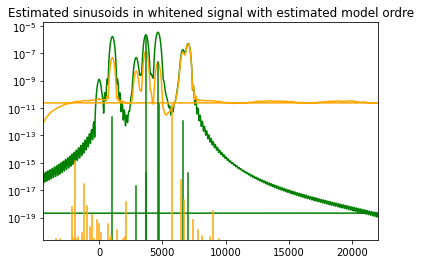

In [18]:
# number of bands
n_fb = 16
m_fb = n_fb//2
step_fb = 4

fs_fb, ts_fb, x_stft = sig.stft(x, fs=sr,
    nperseg=m_fb, nfft=n_fb)

fs_centre = np.fft.fftfreq(n=n_fb)

rs = []
deltas_est = []
nus_est = []
amps_est = []
phis_est = []

n_est_fb = 8
p_max_fb = 4
for k in range(len(fs_centre)):
    x_b = x_stft[k]
    r = Ester.estimate_esm_ordre(x_b, n=n_est_fb, p_max=p_max_fb)
    rs.append(r)
    w, _ = Esprit.spectral_mats(x_b, n_est, rs[k])
    deltas_est_band, nus_est_band = Esprit._estimate_dampfreq(w)
    amps_est_band, phis_est_band = Esprit._estimate_amp(x_b, deltas_est_band, nus_est_band)
    # TODO: Not right, fix this
    nus_est_band = (nus_est_band + fs_centre[k])/step_fb
    nus_est += nus_est_band.tolist()
    deltas_est += deltas_est_band.tolist()
    amps_est += amps_est_band.tolist()
    phis_est += phis_est_band.tolist()

x_esm_est = EsmModel(deltas_est, nus_est, amps_est, phis_est)
print(x_esm_est.nus * sr)

plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='g')
plt.semilogy(fs_x_psd, x_white_psd, c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='orange')
plt.show()

In [19]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)